MLNLP Project
--------------------------------------------

# Authors
    - Selim Lakhdar
        - selim.lakhdar.etu@univ-lille.fr
    - Josue Happe
        - josue.happe.etu@univ-lille.fr

# Libraries

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

random_state = 59

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# Bert

In [2]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

for param in bert.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Data

In [3]:
data = pd.read_csv("Ultimate_Gender_List.csv")
data

,name,gender,score,Right_Name,Right_Gender,Frequency,Include?,probability
0,1,F,NaN,NaN,NaN,38.0,No,NaN
1,1,M,NaN,NaN,NaN,56.0,Yes,NaN
2,A,M,1.0,NaN,NaN,NaN,NaN,NaN
3,A'isha,F,0.0,NaN,NaN,NaN,NaN,NaN
4,A'ishah,F,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
121555,Zyvon,M,1.0,Zyvon,M,6.0,No,1.0
121556,Zyyanna,F,1.0,Zyyanna,F,NaN,NaN,1.0
121557,Zyyon,M,1.0,Zyyon,M,NaN,NaN,1.0
121558,Zzyzx,M,1.0,Zzyzx,M,NaN,NaN,1.0


In [4]:
data['length'] = data['name'].apply(lambda x: len(x))

<AxesSubplot:>

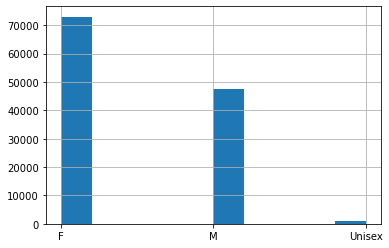

In [5]:
values = data[['name', 'gender', 'length']].values
data_clean = pd.DataFrame(values, columns=['name', 'gender', 'length'])
data_clean = data_clean.astype({'name':'str', 'gender':'str', 'length':'int'}).dropna()
data_clean.gender.hist()

In [6]:
# remove first 3 and last one
data_clean = data_clean[3:-1]

# Catgories
data_clean['gender'] = data_clean['gender'].replace({'F':0, 'M':1, 'Unisex':2})

# add name len
data_clean

,name,gender,length
3,A'isha,0,6
4,A'ishah,0,7
5,A-jay,1,5
6,A.j.,1,4
7,Aa'isha,0,7
...,...,...,...
121554,Zyvion,1,6
121555,Zyvon,1,5
121556,Zyyanna,0,7
121557,Zyyon,1,5


In [7]:
mask_female = data_clean['gender'] == 0
mask_male = data_clean['gender'] == 1
mask_unisex = data_clean['gender'] == 2

data_female = data_clean[mask_female][:3000]
data_male = data_clean[mask_male][:2000]
data_unisex = data_clean[mask_unisex]

data_clean = pd.concat([data_female, data_male, data_unisex])
data_clean

,name,gender,length
3,A'isha,0,6
4,A'ishah,0,7
7,Aa'isha,0,7
8,Aa'ishah,0,8
10,Aabha,0,5
...,...,...,...
120770,Zhuo,2,4
120779,Zhyrgal,2,7
120968,Ziv,2,3
121079,Zohar,2,5


<AxesSubplot:>

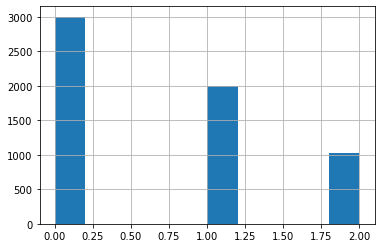

In [8]:
data_clean.gender.hist()

In [9]:
X = data_clean['name'].values
y = data_clean['gender'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.3)

In [10]:
batch_size = 16

train_tokens = tokenizer.batch_encode_plus(
    list(X_train),
    max_length = data_clean['length'].max(),
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

train_seq = torch.tensor(train_tokens['input_ids']).to(device)
train_mask = torch.tensor(train_tokens['attention_mask']).to(device)
train_y = torch.tensor(y_train)

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_tokens = tokenizer.batch_encode_plus(
    list(X_test),
    max_length = data_clean['length'].max(),
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

test_seq = torch.tensor(test_tokens['input_ids']).to(device)
test_mask = torch.tensor(test_tokens['attention_mask']).to(device)
test_y = torch.tensor(y_test)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

# Models

In [11]:
class Model1(nn.Module):
    def __init__(self, bert):
        super(Model1, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        
        # dense layer 2
        self.fc2 = nn.Linear(512,512)
      
        # dense layer 3 (Output layer)
        self.fc3 = nn.Linear(512,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # first layer
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        # second layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc3(x)
        x = self.dropout(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [12]:
class Model2(nn.Module):
    def __init__(self, bert):
        super(Model2, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        
        # dense layer 2
        self.fc2 = nn.Linear(512,64)
      
        # dense layer 3 (Output layer)
        self.fc3 = nn.Linear(64,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # first layer
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        # second layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc3(x)
        x = self.dropout(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [13]:
class Model3(nn.Module):
    def __init__(self, bert):
        super(Model3, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # layer 1
        self.fc1 = nn.Linear(768,512)
        
        # layer 2
        self.fc2 = nn.Linear(512,64)
        
        # dense layer 3
        self.fc3 = nn.Linear(64,64)
      
        # layer 4 (Output layer)
        self.fc4 = nn.Linear(64,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # first layer
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        # second layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # 3
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc4(x)
        x = self.dropout(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [14]:
class Model4(nn.Module):
    def __init__(self, bert):
        super(Model4, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # layer 1
        self.fc1 = nn.Linear(768,512)
        
        # layer 2
        self.fc2 = nn.Linear(512,64)
        
        # layer 3
        self.fc3 = nn.Linear(64,32)
        
        # layer 4
        self.fc4 = nn.Linear(32,32)
      
        # layer 5 (Output layer)
        self.fc5 = nn.Linear(32,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # first layer
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        # second layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # 3
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # 4
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc5(x)
        x = self.dropout(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [15]:
class Model5(nn.Module):
    def __init__(self, bert):
        super(Model5, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # layer 1
        self.fc1 = nn.Linear(768,512)
        
        # layer 2
        self.fc2 = nn.Linear(512,512)
        
        # layer 3 (Output layer)
        self.fc3 = nn.Linear(512,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # first layer
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        # second layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc3(x)
        x = self.dropout(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [16]:
class Model6(nn.Module):
    def __init__(self, bert):
        super(Model6, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # layer 1
        self.fc1 = nn.Linear(768,512)
        
        # layer 2 (Output layer)
        self.fc2 = nn.Linear(512,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # first layer
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        x = self.dropout(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

# Train

In [17]:
def train(model, optim, loss_func, epochs=5):
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = loss_func(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optim.step()


    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  

    # returns avg loss
    return avg_loss

# Test

In [18]:
def test(model, loss_func, epochs=5):  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # iterate over batches
    for step,batch in enumerate(test_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = loss_func(preds,labels)
            total_loss = total_loss + loss.item()

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(test_dataloader) 

    return avg_loss

# Eval

In [19]:
def evaluate(model, optim, loss_func, output_name, epochs=5):
    # set initial loss to infinite
    best_loss = float('inf')

    # empty lists to store training and validation loss of each epoch
    train_losses = []
    test_losses = []

    # for each epoch
    for epoch in range(epochs):

        print("epoch", epoch+1, "/", epochs)

        # train model
        train_loss = train(model, optim, loss_func)

        # evaluate model
        test_loss = test(model, loss_func)

        # save the best model
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), output_name)

        # append training and validation loss
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Training Loss: {train_loss:.3f}')
        print(f'Validation Loss: {test_loss:.3f}')

In [20]:
model1 = Model1(bert).to(device)
model2 = Model2(bert).to(device)
model3 = Model3(bert).to(device)
model4 = Model4(bert).to(device)
model5 = Model5(bert).to(device)
model6 = Model6(bert).to(device)

# init weights
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print("weights:", weights)
weights = torch.tensor(weights, dtype=torch.float).to(device)

# loss function
loss_function  = nn.NLLLoss(weight=weights) 

# define the optimizer
optimizer1 = AdamW(model1.parameters(), lr = 1e-3)
optimizer2 = AdamW(model2.parameters(), lr = 1e-3)
optimizer3 = AdamW(model3.parameters(), lr = 1e-3)
optimizer4 = AdamW(model4.parameters(), lr = 1e-3)
optimizer5 = AdamW(model5.parameters(), lr = 1e-3)
optimizer6 = AdamW(model6.parameters(), lr = 1e-3)

weights: [0.66320428 1.01493256 1.97284644]


/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 0 1 ... 0 2 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [21]:
evaluate(model1, optimizer1, loss_function, 'model1.pt')

epoch 1 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.111
Validation Loss: 1.098
epoch 2 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.096
Validation Loss: 1.091
epoch 3 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.091
Validation Loss: 1.060
epoch 4 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.065
Validation Loss: 0.992
epoch 5 / 5
  Batch    50  of    264.
  Batch   

In [22]:
evaluate(model2, optimizer2, loss_function, 'model2.pt')

epoch 1 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.110
Validation Loss: 1.098
epoch 2 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.103
Validation Loss: 1.085
epoch 3 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.097
Validation Loss: 1.075
epoch 4 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.082
Validation Loss: 1.067
epoch 5 / 5
  Batch    50  of    264.
  Batch   

In [23]:
evaluate(model3, optimizer3, loss_function, 'model3.pt')

epoch 1 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.106
Validation Loss: 1.097
epoch 2 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.100
Validation Loss: 1.091
epoch 3 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.095
Validation Loss: 1.078
epoch 4 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.089
Validation Loss: 1.073
epoch 5 / 5
  Batch    50  of    264.
  Batch   

In [24]:
evaluate(model4, optimizer4, loss_function, 'model4.pt')

epoch 1 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.101
Validation Loss: 1.095
epoch 2 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.098
Validation Loss: 1.097
epoch 3 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.098
Validation Loss: 1.090
epoch 4 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.095
Validation Loss: 1.088
epoch 5 / 5
  Batch    50  of    264.
  Batch   

In [25]:
evaluate(model5, optimizer5, loss_function, 'model5.pt')

epoch 1 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.115
Validation Loss: 1.090
epoch 2 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.103
Validation Loss: 1.097
epoch 3 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.097
Validation Loss: 1.084
epoch 4 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.102
Validation Loss: 1.066
epoch 5 / 5
  Batch    50  of    264.
  Batch   

In [26]:
evaluate(model6, optimizer6, loss_function, 'model6.pt')

epoch 1 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.119
Validation Loss: 1.037
epoch 2 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.070
Validation Loss: 1.006
epoch 3 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.043
Validation Loss: 1.073
epoch 4 / 5
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.
  Batch    50  of    113.
  Batch   100  of    113.
Training Loss: 1.011
Validation Loss: 0.899
epoch 5 / 5
  Batch    50  of    264.
  Batch   

# Pred

In [27]:
with torch.no_grad():
    pred1_prob = model1(test_seq, test_mask).detach().cpu().numpy()
    pred2_prob = model2(test_seq, test_mask).detach().cpu().numpy()
    pred3_prob = model3(test_seq, test_mask).detach().cpu().numpy()
    pred4_prob = model4(test_seq, test_mask).detach().cpu().numpy()
    pred5_prob = model5(test_seq, test_mask).detach().cpu().numpy()
    pred6_prob = model6(test_seq, test_mask).detach().cpu().numpy()
    
pred1 = np.argmax(pred1_prob, axis = 1)
pred2 = np.argmax(pred2_prob, axis = 1)
pred3 = np.argmax(pred3_prob, axis = 1)
pred4 = np.argmax(pred4_prob, axis = 1)
pred5 = np.argmax(pred5_prob, axis = 1)
pred6 = np.argmax(pred6_prob, axis = 1)

In [28]:
print("Model 1 scores:")
print(classification_report(y_test, pred1))
print("=" * 50)
print("Model 2 scores:")
print(classification_report(y_test, pred2))
print("=" * 50)
print("Model 3 scores:")
print(classification_report(y_test, pred3))
print("=" * 50)
print("Model 4 scores:")
print(classification_report(y_test, pred4))
print("=" * 50)
print("Model 5 scores:")
print(classification_report(y_test, pred5))
print("=" * 50)
print("Model 6 scores:")
print(classification_report(y_test, pred6))

Model 1 scores:
              precision    recall  f1-score   support

           0       0.63      0.91      0.75       882
           1       0.75      0.56      0.64       616
           2       0.61      0.15      0.23       309

    accuracy                           0.66      1807
   macro avg       0.66      0.54      0.54      1807
weighted avg       0.67      0.66      0.62      1807

Model 2 scores:
              precision    recall  f1-score   support

           0       0.59      0.83      0.69       882
           1       0.60      0.25      0.36       616
           2       0.35      0.34      0.34       309

    accuracy                           0.55      1807
   macro avg       0.51      0.48      0.46      1807
weighted avg       0.55      0.55      0.52      1807

Model 3 scores:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       882
           1       0.68      0.56      0.61       616
           2       0.35    

/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda/envs/SD/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
